<a href="https://colab.research.google.com/github/Meta-user-byte/Percevel/blob/main/Quantum%20hybrid%20challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install perceval-quandela==0.11.2 torch torchvision matplotlib numpy pandas


INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.9/346.9 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.6 MB/s eta

Boson sampler defined with number of parameters = 855, and embedding size = 435
DEVICE = cuda:0


100%|██████████| 6000/6000 [00:10<00:00, 597.34it/s]


Epoch [0], val_loss: 0.7747, val_acc: 0.8500


100%|██████████| 6000/6000 [00:09<00:00, 621.49it/s]


Epoch [1], val_loss: 0.5890, val_acc: 0.8567


100%|██████████| 6000/6000 [00:09<00:00, 660.10it/s]


Epoch [2], val_loss: 0.5177, val_acc: 0.8583


100%|██████████| 6000/6000 [00:09<00:00, 614.78it/s]


Epoch [3], val_loss: 0.4745, val_acc: 0.8767


100%|██████████| 6000/6000 [00:10<00:00, 592.61it/s]


Epoch [4], val_loss: 0.4470, val_acc: 0.8817


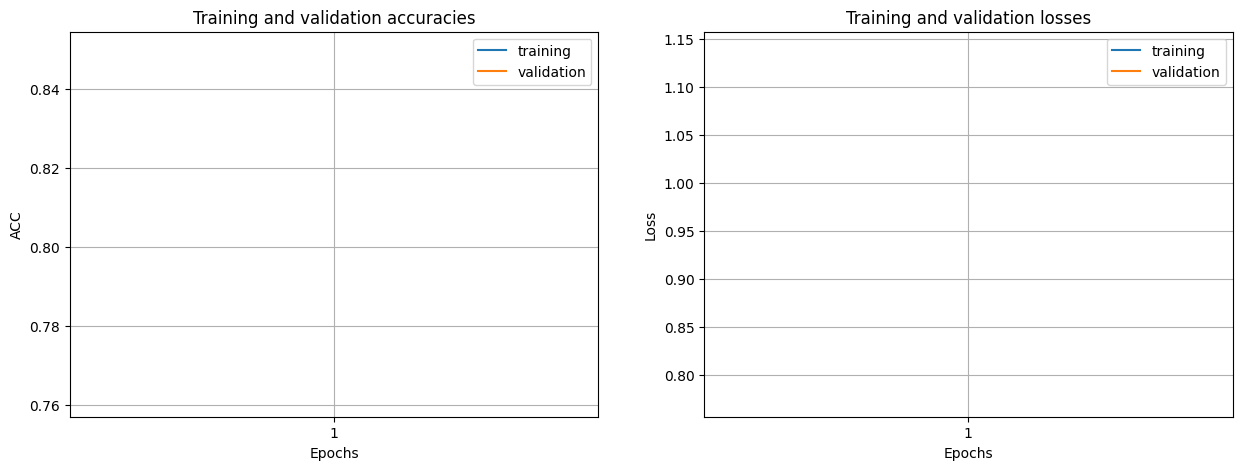

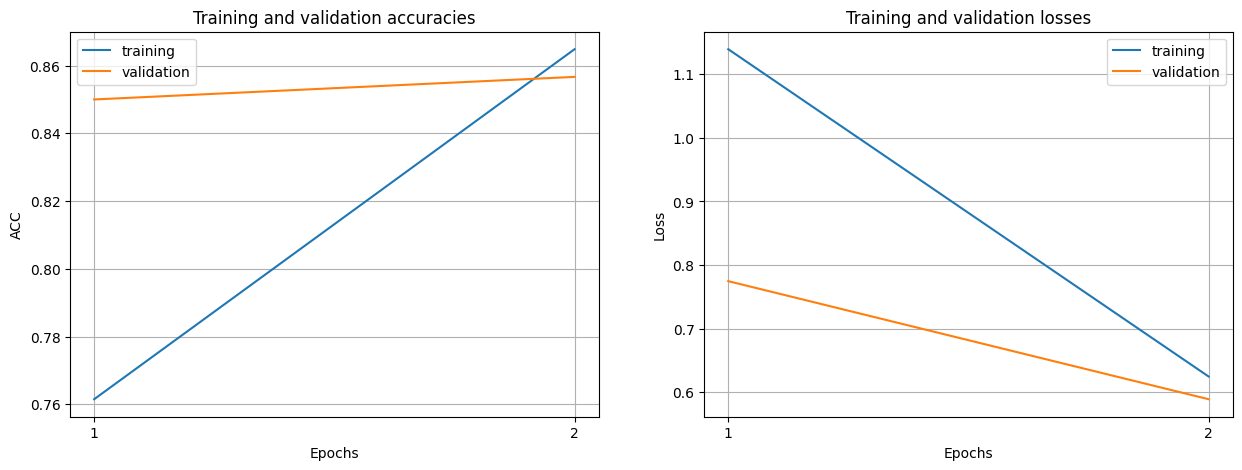

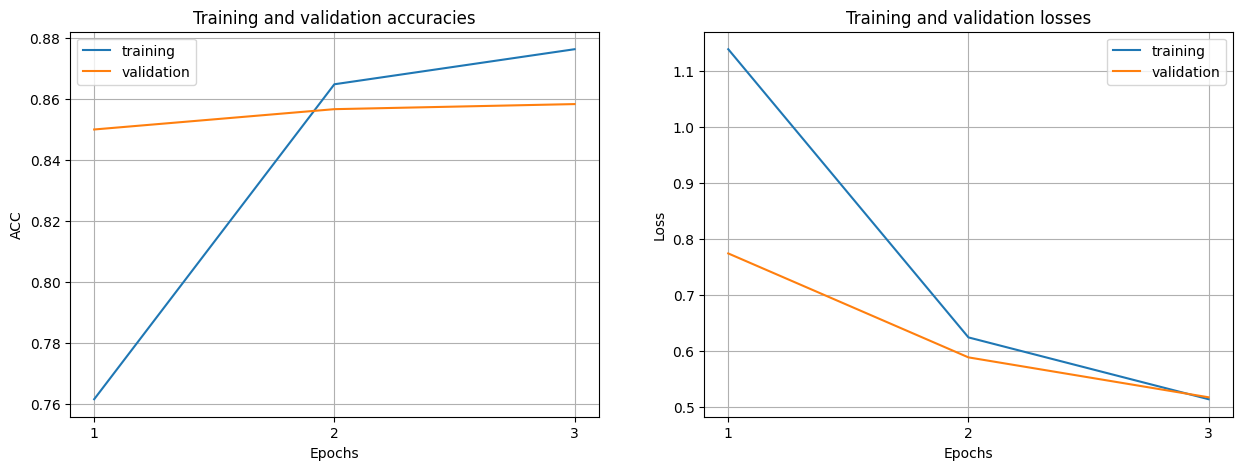

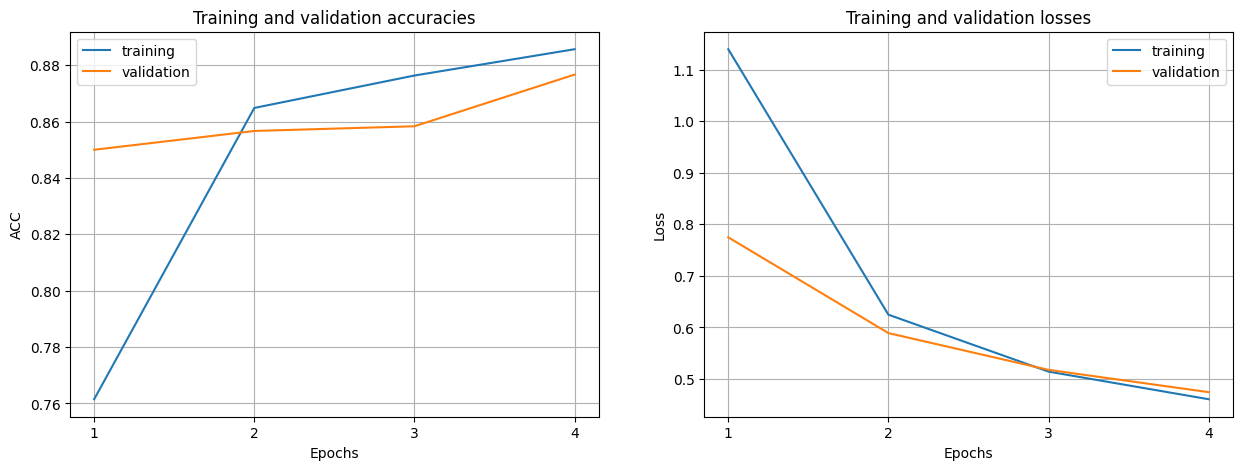

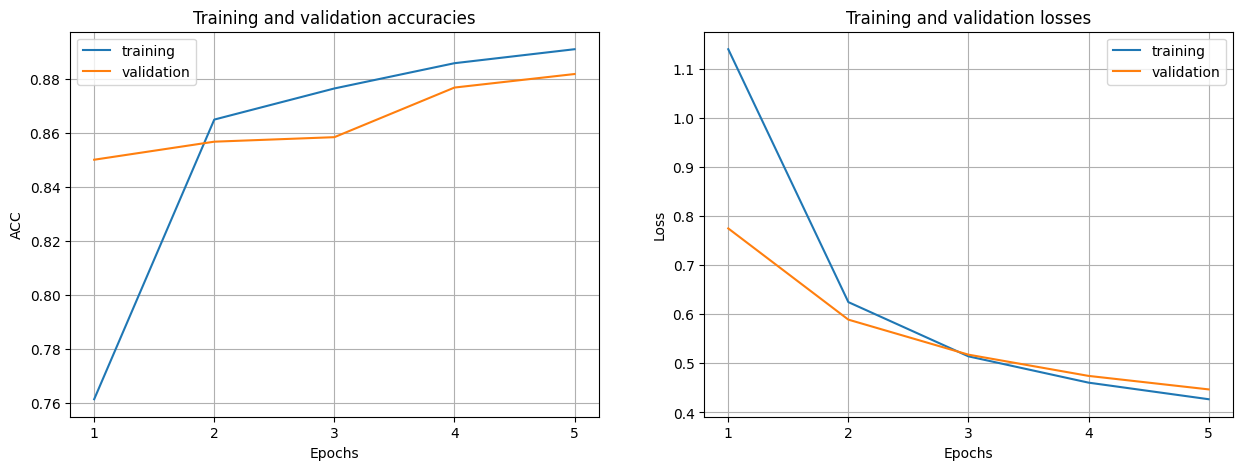

In [16]:
import perceval as pcvl
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from model import MnistModel
from training import fit

from utils import MNIST_partial, plot_training_metrics
from boson_sampler import BosonSampler
import perceval.providers.scaleway as scw


In [6]:
from google.colab import files
uploaded = files.upload()  # Upload train.csv and val.csv


Saving train.csv to train (1).csv


In [7]:
from google.colab import files
uploaded = files.upload()  # Upload train.csv and val.csv


Saving val.csv to val (1).csv


In [8]:
import os
os.makedirs('./data', exist_ok=True)
!mv train.csv ./data/
!mv val.csv ./data/


In [9]:
import torch.nn as nn
import torch.nn.functional as F

class ClassicalCNN(nn.Module):
    def __init__(self, embedding_size=0):
        super(ClassicalCNN, self).__init__()
        self.embedding_size = embedding_size

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()

        fc_input_size = 64 * 7 * 7
        if embedding_size:
            fc_input_size += embedding_size  # Adjust for quantum embedding

        self.fc1 = nn.Linear(fc_input_size, 128)
        self.fc2 = nn.Linear(128, 10)  # MNIST has 10 classes

    def forward(self, x, emb=None):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flatten(x)
        if emb is not None:
            x = torch.cat((x, emb), dim=1)  # Concatenate classical and quantum embeddings
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [10]:
def build_boson_sampler(modes=3):
    circuit = pcvl.Circuit(modes)
    for i in range(modes - 1):
        circuit.add((i, i + 1), pcvl.BS())
    return circuit

def encode_classical_data(circuit, classical_data):
    circuit.clear()
    for i, pixel in enumerate(classical_data):
        phase_shift = 2 * np.pi * pixel
        circuit.add(i % circuit.m, pcvl.PS(phase_shift))


In [11]:
def simulate_boson_sampler(circuit):
    backend = pcvl.BackendFactory().get_backend('SLOS')
    backend.set_circuit(circuit)
    backend.set_input_state(pcvl.BasicState([1, 0, 0]))  # Inject 1 photon
    return backend.prob_distribution()


In [12]:
class QuantumEmbeddingLayer(nn.Module):
    def __init__(self, modes=3):
        super(QuantumEmbeddingLayer, self).__init__()
        self.modes = modes
        self.circuit = build_boson_sampler(modes)
        self.backend = pcvl.BackendFactory().get_backend('SLOS')

    def forward(self, x):
        batch_size = x.shape[0]
        embeddings = []
        for i in range(batch_size):
            emb = simulate_boson_sampler(self.circuit).values()
            embeddings.append(torch.tensor(list(emb)))
        return torch.stack(embeddings)


In [13]:
class HybridModel(nn.Module):
    def __init__(self, embedding_size=0, modes=3):
        super(HybridModel, self).__init__()
        self.cnn = ClassicalCNN(embedding_size)
        self.quantum_layer = QuantumEmbeddingLayer(modes=modes)

    def forward(self, x):
        emb = self.quantum_layer(x)
        return self.cnn(x, emb)


In [14]:
train_dataset = MNIST_partial(split='train')
val_dataset = MNIST_partial(split='val')

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)


Boson sampler defined with embedding size = 435


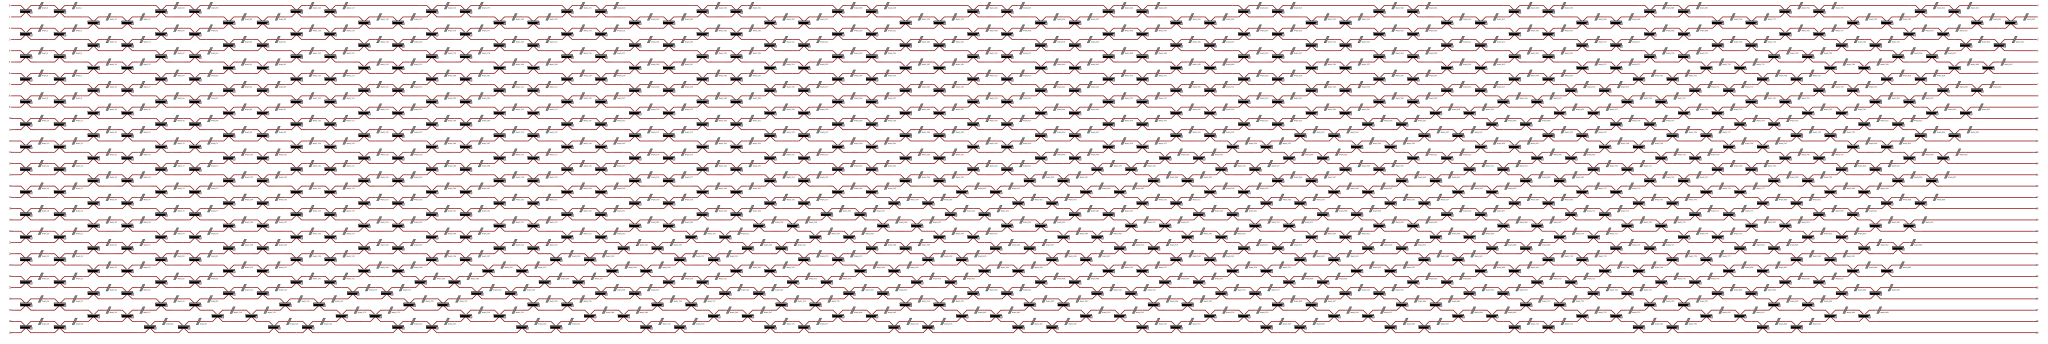

In [15]:
bs = BosonSampler(30, 2, postselect=2)
print(f"Boson sampler defined with embedding size = {bs.embedding_size}")
pcvl.pdisplay(bs.create_circuit())


  0%|          | 1/6000 [00:00<55:08,  1.81it/s]

STEP 0, Training-acc = 0.0, Training-losses = 2.284172534942627


  2%|▏         | 101/6000 [01:05<1:09:44,  1.41it/s]

STEP 100, Training-acc = 0.22772277227722773, Training-losses = 2.231134480769091


  3%|▎         | 201/6000 [02:11<1:13:18,  1.32it/s]

STEP 200, Training-acc = 0.27860696517412936, Training-losses = 2.1917797481242696


  5%|▌         | 301/6000 [03:16<1:17:31,  1.23it/s]

STEP 300, Training-acc = 0.31561461794019935, Training-losses = 2.1579018308474773


  7%|▋         | 401/6000 [04:21<1:19:51,  1.17it/s]

STEP 400, Training-acc = 0.35910224438902744, Training-losses = 2.122304946407118


  8%|▊         | 501/6000 [05:26<1:11:14,  1.29it/s]

STEP 500, Training-acc = 0.3872255489021956, Training-losses = 2.0783934869214207


 10%|█         | 601/6000 [06:31<1:14:20,  1.21it/s]

STEP 600, Training-acc = 0.415973377703827, Training-losses = 2.043076892462427


 12%|█▏        | 701/6000 [07:37<1:11:16,  1.24it/s]

STEP 700, Training-acc = 0.44365192582025675, Training-losses = 2.007119421271897


 13%|█▎        | 801/6000 [08:43<1:15:10,  1.15it/s]

STEP 800, Training-acc = 0.4706616729088639, Training-losses = 1.9701620108923512


 15%|█▌        | 901/6000 [09:49<1:05:22,  1.30it/s]

STEP 900, Training-acc = 0.5005549389567148, Training-losses = 1.9285030867759714


 17%|█▋        | 1001/6000 [10:54<59:31,  1.40it/s]

STEP 1000, Training-acc = 0.5254745254745254, Training-losses = 1.8944432543112444


 18%|█▊        | 1101/6000 [11:59<1:00:21,  1.35it/s]

STEP 1100, Training-acc = 0.5485921889191644, Training-losses = 1.8547566727439888


 20%|██        | 1201/6000 [13:04<52:10,  1.53it/s]

STEP 1200, Training-acc = 0.5620316402997502, Training-losses = 1.8262231512976923


 22%|██▏       | 1301/6000 [14:08<49:01,  1.60it/s]

STEP 1300, Training-acc = 0.5772482705611068, Training-losses = 1.7966392732280478


 23%|██▎       | 1401/6000 [15:14<44:09,  1.74it/s]

STEP 1400, Training-acc = 0.5874375446109922, Training-losses = 1.77001629949552


 25%|██▌       | 1501/6000 [16:19<47:43,  1.57it/s]

STEP 1500, Training-acc = 0.597601598934044, Training-losses = 1.7427995456289562


 27%|██▋       | 1601/6000 [17:25<42:55,  1.71it/s]

STEP 1600, Training-acc = 0.6121174266083698, Training-losses = 1.7122020204315924


 28%|██▊       | 1701/6000 [18:30<40:26,  1.77it/s]

STEP 1700, Training-acc = 0.6184597295708407, Training-losses = 1.6917429923012564


 30%|███       | 1801/6000 [19:36<42:02,  1.66it/s]

STEP 1800, Training-acc = 0.6268739589117157, Training-losses = 1.6655592304395346


 32%|███▏      | 1901/6000 [20:41<40:24,  1.69it/s]

STEP 1900, Training-acc = 0.6333508679642293, Training-losses = 1.6447253218533051


 33%|███▎      | 2001/6000 [21:47<41:16,  1.61it/s]

STEP 2000, Training-acc = 0.6406796601699151, Training-losses = 1.6257051472244473


 35%|███▌      | 2101/6000 [22:53<37:06,  1.75it/s]

STEP 2100, Training-acc = 0.6487386958591147, Training-losses = 1.6032934692829692


 37%|███▋      | 2201/6000 [23:59<39:23,  1.61it/s]

STEP 2200, Training-acc = 0.6592457973648341, Training-losses = 1.581613723488219


 38%|███▊      | 2301/6000 [25:03<35:37,  1.73it/s]

STEP 2300, Training-acc = 0.6671012603215993, Training-losses = 1.5606572096507636


 40%|████      | 2401/6000 [26:09<38:58,  1.54it/s]

STEP 2400, Training-acc = 0.6726364014993753, Training-losses = 1.5401820785232954


 42%|████▏     | 2501/6000 [27:14<34:25,  1.69it/s]

STEP 2500, Training-acc = 0.6785285885645742, Training-losses = 1.5213242167326175


 43%|████▎     | 2601/6000 [28:19<32:18,  1.75it/s]

STEP 2600, Training-acc = 0.6835832372164552, Training-losses = 1.5050606803824607


 45%|████▌     | 2701/6000 [29:24<33:12,  1.66it/s]

STEP 2700, Training-acc = 0.6878933728248797, Training-losses = 1.4893246261814663


 47%|████▋     | 2801/6000 [30:29<31:38,  1.68it/s]

STEP 2800, Training-acc = 0.694394858978936, Training-losses = 1.4708723765197758


 48%|████▊     | 2901/6000 [31:34<32:33,  1.59it/s]

STEP 2900, Training-acc = 0.6987245777318166, Training-losses = 1.4555107620010208


 50%|█████     | 3001/6000 [32:39<29:33,  1.69it/s]

STEP 3000, Training-acc = 0.700433188937021, Training-losses = 1.4425047316905937


 52%|█████▏    | 3101/6000 [33:44<31:27,  1.54it/s]

STEP 3100, Training-acc = 0.7052563689132538, Training-losses = 1.4282236931276722


 53%|█████▎    | 3201/6000 [34:49<29:16,  1.59it/s]

STEP 3200, Training-acc = 0.7097781943142768, Training-losses = 1.4118728758496666


 55%|█████▌    | 3301/6000 [35:54<32:57,  1.36it/s]

STEP 3300, Training-acc = 0.713420175704332, Training-losses = 1.3941905203618739


 57%|█████▋    | 3401/6000 [36:58<35:54,  1.21it/s]

STEP 3400, Training-acc = 0.7150837988826816, Training-losses = 1.3824899460012967


 58%|█████▊    | 3501/6000 [38:02<29:03,  1.43it/s]

STEP 3500, Training-acc = 0.7189374464438731, Training-losses = 1.3696556091063858


 60%|██████    | 3601/6000 [39:07<26:11,  1.53it/s]

STEP 3600, Training-acc = 0.7225770619272425, Training-losses = 1.3584343734471724


 62%|██████▏   | 3701/6000 [40:12<21:26,  1.79it/s]

STEP 3700, Training-acc = 0.7249392056201027, Training-losses = 1.3466463200375538


 63%|██████▎   | 3801/6000 [41:17<23:11,  1.58it/s]

STEP 3800, Training-acc = 0.7271770586687714, Training-losses = 1.3346350311123518


 65%|██████▌   | 3901/6000 [42:22<20:16,  1.72it/s]

STEP 3900, Training-acc = 0.7280184568059472, Training-losses = 1.326892943576769


 67%|██████▋   | 4001/6000 [43:27<21:42,  1.53it/s]

STEP 4000, Training-acc = 0.7298175456135966, Training-losses = 1.3155233055610145


 68%|██████▊   | 4101/6000 [44:32<18:26,  1.72it/s]

STEP 4100, Training-acc = 0.7332357961472812, Training-losses = 1.3027713268457521


 70%|███████   | 4201/6000 [45:37<19:05,  1.57it/s]

STEP 4200, Training-acc = 0.7367293501547251, Training-losses = 1.2905265275008535


 72%|███████▏  | 4301/6000 [46:42<16:27,  1.72it/s]

STEP 4300, Training-acc = 0.7382004185073239, Training-losses = 1.281860907904854


 73%|███████▎  | 4401/6000 [47:47<15:10,  1.76it/s]

STEP 4400, Training-acc = 0.7409679618268575, Training-losses = 1.2715473177520504


 75%|███████▌  | 4501/6000 [48:52<15:10,  1.65it/s]

STEP 4500, Training-acc = 0.7445012219506776, Training-losses = 1.2605230596079557


 77%|███████▋  | 4601/6000 [49:57<13:51,  1.68it/s]

STEP 4600, Training-acc = 0.7480982395131494, Training-losses = 1.2499749512767706


 78%|███████▊  | 4701/6000 [51:02<13:38,  1.59it/s]

STEP 4700, Training-acc = 0.7485641352903637, Training-losses = 1.2429277029968568


 80%|████████  | 4801/6000 [52:07<12:13,  1.63it/s]

STEP 4800, Training-acc = 0.7504686523640908, Training-losses = 1.2328156375187904


 82%|████████▏ | 4901/6000 [53:13<12:30,  1.46it/s]

STEP 4900, Training-acc = 0.7529075698836972, Training-losses = 1.2228341006423606


 83%|████████▎ | 5001/6000 [54:18<10:43,  1.55it/s]

STEP 5000, Training-acc = 0.7546490701859628, Training-losses = 1.2142517350210331


 85%|████████▌ | 5101/6000 [55:23<09:41,  1.55it/s]

STEP 5100, Training-acc = 0.7565183297392668, Training-losses = 1.2051796920000892


 87%|████████▋ | 5201/6000 [56:28<09:22,  1.42it/s]

STEP 5200, Training-acc = 0.7594693328206115, Training-losses = 1.1957178229741485


 88%|████████▊ | 5301/6000 [57:33<08:20,  1.40it/s]

STEP 5300, Training-acc = 0.7609884927372194, Training-losses = 1.1881754388271992


 90%|█████████ | 5401/6000 [58:37<07:58,  1.25it/s]

STEP 5400, Training-acc = 0.7624513978892797, Training-losses = 1.180929701201103


 92%|█████████▏| 5501/6000 [59:41<05:37,  1.48it/s]

STEP 5500, Training-acc = 0.7636793310307217, Training-losses = 1.1736766401779226


 93%|█████████▎| 5601/6000 [1:00:46<04:57,  1.34it/s]

STEP 5600, Training-acc = 0.7655775754329583, Training-losses = 1.1652570677878942


 95%|█████████▌| 5701/6000 [1:01:50<03:21,  1.48it/s]

STEP 5700, Training-acc = 0.7663567795123662, Training-losses = 1.1584233101271126


 97%|█████████▋| 5801/6000 [1:02:56<02:18,  1.44it/s]

STEP 5800, Training-acc = 0.7679710394759525, Training-losses = 1.1519431257641324


 98%|█████████▊| 5901/6000 [1:04:00<00:57,  1.71it/s]

STEP 5900, Training-acc = 0.7690221996271819, Training-losses = 1.1455708669706575


100%|██████████| 600/600 [06:32<00:00,  1.53it/s]


Epoch [0], val_loss: 0.7654, val_acc: 0.8333


  0%|          | 1/6000 [00:00<55:48,  1.79it/s]

STEP 0, Training-acc = 0.0, Training-losses = 1.4677908420562744


  2%|▏         | 101/6000 [01:06<1:03:51,  1.54it/s]

STEP 100, Training-acc = 0.9306930693069307, Training-losses = 0.597999698602327


  3%|▎         | 201/6000 [02:12<57:28,  1.68it/s]

STEP 200, Training-acc = 0.8805970149253731, Training-losses = 0.6584337140938535


  5%|▌         | 301/6000 [03:17<55:35,  1.71it/s]

STEP 300, Training-acc = 0.8538205980066446, Training-losses = 0.6983801953160387


  7%|▋         | 401/6000 [04:23<57:57,  1.61it/s]  

STEP 400, Training-acc = 0.8478802992518704, Training-losses = 0.694803774589092


  8%|▊         | 501/6000 [05:29<54:29,  1.68it/s]

STEP 500, Training-acc = 0.844311377245509, Training-losses = 0.698541998640149


 10%|█         | 601/6000 [06:34<51:22,  1.75it/s]

STEP 600, Training-acc = 0.8569051580698835, Training-losses = 0.6754035819910728


 12%|█▏        | 701/6000 [07:40<56:23,  1.57it/s]

STEP 700, Training-acc = 0.854493580599144, Training-losses = 0.6798651497997078


 13%|█▎        | 801/6000 [08:46<51:50,  1.67it/s]

STEP 800, Training-acc = 0.850187265917603, Training-losses = 0.6857319059694528


 15%|█▌        | 901/6000 [09:51<47:57,  1.77it/s]

STEP 900, Training-acc = 0.8468368479467259, Training-losses = 0.6784342318508654


 17%|█▋        | 1001/6000 [10:56<51:26,  1.62it/s]

STEP 1000, Training-acc = 0.8451548451548452, Training-losses = 0.6785862260478568


 18%|█▊        | 1101/6000 [12:02<48:00,  1.70it/s]

STEP 1100, Training-acc = 0.8483197093551317, Training-losses = 0.6790417594095857


 20%|██        | 1201/6000 [13:08<52:21,  1.53it/s]

STEP 1200, Training-acc = 0.8534554537885096, Training-losses = 0.6669860141147098


 22%|██▏       | 1301/6000 [14:13<47:00,  1.67it/s]

STEP 1300, Training-acc = 0.8547271329746349, Training-losses = 0.663989260495654


 23%|██▎       | 1401/6000 [15:19<43:57,  1.74it/s]

STEP 1400, Training-acc = 0.8558172733761599, Training-losses = 0.6606859952207391


 25%|██▌       | 1501/6000 [16:25<46:42,  1.61it/s]

STEP 1500, Training-acc = 0.8560959360426382, Training-losses = 0.6576245571260181


 27%|██▋       | 1601/6000 [17:30<42:56,  1.71it/s]

STEP 1600, Training-acc = 0.8569643972517177, Training-losses = 0.6557404807274888


 28%|██▊       | 1701/6000 [18:35<40:29,  1.77it/s]

STEP 1700, Training-acc = 0.8583186360964139, Training-losses = 0.6544282398543056


 30%|███       | 1801/6000 [19:41<44:41,  1.57it/s]

STEP 1800, Training-acc = 0.8595224875069406, Training-losses = 0.655092483221438


 32%|███▏      | 1901/6000 [20:47<39:38,  1.72it/s]

STEP 1900, Training-acc = 0.8590215675960021, Training-losses = 0.6570131546866221


 33%|███▎      | 2001/6000 [21:53<42:57,  1.55it/s]

STEP 2000, Training-acc = 0.8595702148925537, Training-losses = 0.6576547141283237


 35%|███▌      | 2101/6000 [22:58<39:14,  1.66it/s]

STEP 2100, Training-acc = 0.8595906711089957, Training-losses = 0.6538892782994522


 37%|███▋      | 2201/6000 [24:04<36:08,  1.75it/s]

STEP 2200, Training-acc = 0.8577919127669241, Training-losses = 0.6607175420604559


 38%|███▊      | 2301/6000 [25:10<40:38,  1.52it/s]

STEP 2300, Training-acc = 0.8570186875271621, Training-losses = 0.6603351860231874


 40%|████      | 2401/6000 [26:16<35:54,  1.67it/s]

STEP 2400, Training-acc = 0.8579758433985839, Training-losses = 0.656865875566978


 42%|████▏     | 2501/6000 [27:22<34:10,  1.71it/s]

STEP 2500, Training-acc = 0.8604558176729308, Training-losses = 0.6540151604187594


 43%|████▎     | 2601/6000 [28:28<39:37,  1.43it/s]

STEP 2600, Training-acc = 0.8604382929642446, Training-losses = 0.6500691343981505


 45%|████▌     | 2701/6000 [29:34<35:12,  1.56it/s]

STEP 2700, Training-acc = 0.8600518326545724, Training-losses = 0.6511625646560438


 47%|████▋     | 2801/6000 [30:41<37:24,  1.43it/s]

STEP 2800, Training-acc = 0.8593359514459121, Training-losses = 0.6512435654747496


 48%|████▊     | 2901/6000 [31:47<39:40,  1.30it/s]

STEP 2900, Training-acc = 0.8607376766632195, Training-losses = 0.6479296081833302


 50%|█████     | 3001/6000 [32:52<30:07,  1.66it/s]

STEP 3000, Training-acc = 0.8590469843385539, Training-losses = 0.6506092192161976


 52%|█████▏    | 3101/6000 [33:57<27:34,  1.75it/s]

STEP 3100, Training-acc = 0.8603676233473073, Training-losses = 0.6479153211334566


 53%|█████▎    | 3201/6000 [35:03<27:58,  1.67it/s]

STEP 3200, Training-acc = 0.8606685410809122, Training-losses = 0.6481331963102562


 55%|█████▌    | 3301/6000 [36:08<26:31,  1.70it/s]

STEP 3300, Training-acc = 0.8603453498939715, Training-losses = 0.6460578093385356


 57%|█████▋    | 3401/6000 [37:14<29:32,  1.47it/s]

STEP 3400, Training-acc = 0.8594531020288151, Training-losses = 0.6493672314884513


 58%|█████▊    | 3501/6000 [38:19<26:00,  1.60it/s]

STEP 3500, Training-acc = 0.8606112539274493, Training-losses = 0.6479274325098835


 60%|██████    | 3601/6000 [39:26<25:32,  1.57it/s]

STEP 3600, Training-acc = 0.8597611774507081, Training-losses = 0.6486216458745179


 62%|██████▏   | 3701/6000 [40:32<25:44,  1.49it/s]

STEP 3700, Training-acc = 0.8594974331261821, Training-losses = 0.6499853102768117


 63%|██████▎   | 3801/6000 [41:37<24:45,  1.48it/s]

STEP 3800, Training-acc = 0.8605630097342805, Training-losses = 0.6455423684678756


 65%|██████▌   | 3901/6000 [42:43<24:50,  1.41it/s]

STEP 3900, Training-acc = 0.8613176108690079, Training-losses = 0.6408068032956032


 67%|██████▋   | 4001/6000 [43:49<23:19,  1.43it/s]

STEP 4000, Training-acc = 0.8592851787053236, Training-losses = 0.643739107760776


 68%|██████▊   | 4101/6000 [44:54<19:38,  1.61it/s]

STEP 4100, Training-acc = 0.8597902950499878, Training-losses = 0.6416130565821996


 70%|███████   | 4201/6000 [46:01<22:50,  1.31it/s]

STEP 4200, Training-acc = 0.8600333253987146, Training-losses = 0.6405365884321117


 72%|███████▏  | 4301/6000 [47:07<20:37,  1.37it/s]

STEP 4300, Training-acc = 0.8607300627760985, Training-losses = 0.6372463946015039


 73%|███████▎  | 4401/6000 [48:13<20:20,  1.31it/s]

STEP 4400, Training-acc = 0.8609406952965235, Training-losses = 0.6367063888152259


 75%|███████▌  | 4501/6000 [49:20<20:39,  1.21it/s]

STEP 4500, Training-acc = 0.8615863141524106, Training-losses = 0.6344945190623991


 77%|███████▋  | 4601/6000 [50:27<17:06,  1.36it/s]

STEP 4600, Training-acc = 0.8591610519452293, Training-losses = 0.6364176198146861


 78%|███████▊  | 4701/6000 [51:33<16:14,  1.33it/s]

STEP 4700, Training-acc = 0.8589661774090619, Training-losses = 0.6369815899465899


 80%|████████  | 4801/6000 [52:39<14:03,  1.42it/s]

STEP 4800, Training-acc = 0.8600291605915434, Training-losses = 0.634405850265113


 82%|████████▏ | 4901/6000 [53:45<11:54,  1.54it/s]

STEP 4900, Training-acc = 0.8606406855743726, Training-losses = 0.6331572343422022


 83%|████████▎ | 5001/6000 [54:51<12:00,  1.39it/s]

STEP 5000, Training-acc = 0.860627874425115, Training-losses = 0.6322162314118858


 85%|████████▌ | 5101/6000 [55:55<10:19,  1.45it/s]

STEP 5100, Training-acc = 0.860419525583219, Training-losses = 0.631466393327511


 87%|████████▋ | 5201/6000 [57:01<08:56,  1.49it/s]

STEP 5200, Training-acc = 0.8602191886175735, Training-losses = 0.6321099471424216


 88%|████████▊ | 5301/6000 [58:07<08:40,  1.34it/s]

STEP 5300, Training-acc = 0.8602150537634409, Training-losses = 0.6310194498966339


 90%|█████████ | 5401/6000 [59:12<06:33,  1.52it/s]

STEP 5400, Training-acc = 0.8613219774115904, Training-losses = 0.6294911990769537


 92%|█████████▏| 5501/6000 [1:00:18<06:04,  1.37it/s]

STEP 5500, Training-acc = 0.8620250863479367, Training-losses = 0.6269143506303196


 93%|█████████▎| 5601/6000 [1:01:24<04:22,  1.52it/s]

STEP 5600, Training-acc = 0.8614533119085878, Training-losses = 0.6265903256082476


 95%|█████████▌| 5701/6000 [1:02:30<03:12,  1.56it/s]

STEP 5700, Training-acc = 0.8617786353271356, Training-losses = 0.6255225583980697


 97%|█████████▋| 5801/6000 [1:03:36<02:14,  1.48it/s]

STEP 5800, Training-acc = 0.8619203585588692, Training-losses = 0.6239825927821312


 98%|█████████▊| 5901/6000 [1:04:41<01:03,  1.57it/s]

STEP 5900, Training-acc = 0.8622267412303, Training-losses = 0.6229068166732572


100%|██████████| 600/600 [06:35<00:00,  1.52it/s]


Epoch [1], val_loss: 0.5918, val_acc: 0.8583


  0%|          | 1/6000 [00:00<54:56,  1.82it/s]

STEP 0, Training-acc = 1.0, Training-losses = 0.3772510290145874


  2%|▏         | 101/6000 [01:06<59:18,  1.66it/s]  

STEP 100, Training-acc = 0.900990099009901, Training-losses = 0.48977084089955775


  3%|▎         | 201/6000 [02:12<1:05:08,  1.48it/s]

STEP 200, Training-acc = 0.900497512437811, Training-losses = 0.4975645048451142


  5%|▌         | 301/6000 [03:18<1:00:36,  1.57it/s]

STEP 300, Training-acc = 0.9003322259136213, Training-losses = 0.48547800948558706


  7%|▋         | 401/6000 [04:25<56:08,  1.66it/s]

STEP 400, Training-acc = 0.9102244389027432, Training-losses = 0.4566070111108447


  8%|▊         | 501/6000 [05:30<52:59,  1.73it/s]

STEP 500, Training-acc = 0.9041916167664671, Training-losses = 0.46654440188676327


 10%|█         | 601/6000 [06:35<59:29,  1.51it/s]

STEP 600, Training-acc = 0.9001663893510815, Training-losses = 0.46917142207035406


 12%|█▏        | 701/6000 [07:42<55:36,  1.59it/s]

STEP 700, Training-acc = 0.8901569186875892, Training-losses = 0.4957657466893657


 13%|█▎        | 801/6000 [08:48<50:58,  1.70it/s]

STEP 800, Training-acc = 0.8963795255930087, Training-losses = 0.48801745134248825


 15%|█▌        | 901/6000 [09:55<56:03,  1.52it/s]

STEP 900, Training-acc = 0.8956714761376249, Training-losses = 0.4894749441320546


 17%|█▋        | 1001/6000 [11:01<52:01,  1.60it/s]

STEP 1000, Training-acc = 0.8901098901098901, Training-losses = 0.4971870176850462


 18%|█▊        | 1101/6000 [12:09<51:40,  1.58it/s]

STEP 1100, Training-acc = 0.8864668483197093, Training-losses = 0.5018199229698381


 20%|██        | 1201/6000 [13:15<46:17,  1.73it/s]

STEP 1200, Training-acc = 0.8859283930058285, Training-losses = 0.5042088660411537


 22%|██▏       | 1301/6000 [14:22<51:14,  1.53it/s]

STEP 1300, Training-acc = 0.8877786318216756, Training-losses = 0.5061012065413191


 23%|██▎       | 1401/6000 [15:28<55:48,  1.37it/s]

STEP 1400, Training-acc = 0.887937187723055, Training-losses = 0.5029439234814947


 25%|██▌       | 1501/6000 [16:34<54:14,  1.38it/s]

STEP 1500, Training-acc = 0.8860759493670886, Training-losses = 0.5030593389141399


 27%|██▋       | 1601/6000 [17:41<57:02,  1.29it/s]

STEP 1600, Training-acc = 0.8844472204871955, Training-losses = 0.5068993663473775


 28%|██▊       | 1701/6000 [18:48<59:59,  1.19it/s]

STEP 1700, Training-acc = 0.8835978835978836, Training-losses = 0.509148557008606


 30%|███       | 1801/6000 [19:53<56:35,  1.24it/s]

STEP 1800, Training-acc = 0.8817323709050527, Training-losses = 0.5129947464031192


 32%|███▏      | 1901/6000 [21:00<50:03,  1.36it/s]

STEP 1900, Training-acc = 0.882167280378748, Training-losses = 0.516173134014713


 33%|███▎      | 2001/6000 [22:06<50:55,  1.31it/s]

STEP 2000, Training-acc = 0.88055972013993, Training-losses = 0.5195515292159317


 35%|███▌      | 2101/6000 [23:12<43:56,  1.48it/s]

STEP 2100, Training-acc = 0.8776772965254641, Training-losses = 0.5235078635487904


 37%|███▋      | 2201/6000 [24:18<40:37,  1.56it/s]

STEP 2200, Training-acc = 0.8791458427987279, Training-losses = 0.5198311057896554


 38%|███▊      | 2301/6000 [25:24<38:43,  1.59it/s]

STEP 2300, Training-acc = 0.8800521512385919, Training-losses = 0.5192331523204045


 40%|████      | 2401/6000 [26:30<40:34,  1.48it/s]

STEP 2400, Training-acc = 0.880466472303207, Training-losses = 0.5180979015212351


 42%|████▏     | 2501/6000 [27:35<36:48,  1.58it/s]

STEP 2500, Training-acc = 0.8800479808076769, Training-losses = 0.5165200807672345


 43%|████▎     | 2601/6000 [28:40<35:02,  1.62it/s]

STEP 2600, Training-acc = 0.8800461361014994, Training-losses = 0.5178674754009198


 45%|████▌     | 2701/6000 [29:46<40:28,  1.36it/s]

STEP 2700, Training-acc = 0.8774527952610144, Training-losses = 0.5231651519007997


 47%|████▋     | 2801/6000 [30:52<36:51,  1.45it/s]

STEP 2800, Training-acc = 0.8761156729739379, Training-losses = 0.5246113850631223


 48%|████▊     | 2901/6000 [31:57<33:53,  1.52it/s]

STEP 2900, Training-acc = 0.8762495691140986, Training-losses = 0.5230093535703761


 50%|█████     | 3001/6000 [33:03<36:53,  1.35it/s]

STEP 3000, Training-acc = 0.878373875374875, Training-losses = 0.5203831618781624


 52%|█████▏    | 3101/6000 [34:09<32:42,  1.48it/s]

STEP 3100, Training-acc = 0.8787487907126733, Training-losses = 0.5191848296267412


 53%|█████▎    | 3201/6000 [35:14<31:00,  1.50it/s]

STEP 3200, Training-acc = 0.880037488284911, Training-losses = 0.5178452136716726


 55%|█████▌    | 3301/6000 [36:20<28:19,  1.59it/s]

STEP 3300, Training-acc = 0.8794304756134504, Training-losses = 0.5180100433633377


 57%|█████▋    | 3401/6000 [37:25<30:00,  1.44it/s]

STEP 3400, Training-acc = 0.8803293149073802, Training-losses = 0.5165628825458245


 58%|█████▊    | 3501/6000 [38:31<27:38,  1.51it/s]

STEP 3500, Training-acc = 0.8814624393030562, Training-losses = 0.5124320613285641


 60%|██████    | 3601/6000 [39:37<25:05,  1.59it/s]

STEP 3600, Training-acc = 0.8816995279089141, Training-losses = 0.5109390515930239


 62%|██████▏   | 3701/6000 [40:43<27:16,  1.40it/s]

STEP 3700, Training-acc = 0.8824641988651716, Training-losses = 0.5093732143176838


 63%|██████▎   | 3801/6000 [41:49<23:45,  1.54it/s]

STEP 3800, Training-acc = 0.8826624572480926, Training-losses = 0.5112383081881849


 65%|██████▌   | 3901/6000 [42:54<22:13,  1.57it/s]

STEP 3900, Training-acc = 0.8820815175596001, Training-losses = 0.5117539024887768


 67%|██████▋   | 4001/6000 [44:01<20:47,  1.60it/s]

STEP 4000, Training-acc = 0.8817795551112222, Training-losses = 0.5124888797537653


 68%|██████▊   | 4101/6000 [45:07<21:37,  1.46it/s]

STEP 4100, Training-acc = 0.8812484759814679, Training-losses = 0.5126460926190586


 70%|███████   | 4201/6000 [46:12<18:59,  1.58it/s]

STEP 4200, Training-acc = 0.880980718876458, Training-losses = 0.5114629863942542


 72%|███████▏  | 4301/6000 [47:18<16:42,  1.69it/s]

STEP 4300, Training-acc = 0.8814229249011858, Training-losses = 0.5106598566218544


 73%|███████▎  | 4401/6000 [48:25<17:41,  1.51it/s]

STEP 4400, Training-acc = 0.8804817087025676, Training-losses = 0.5124359150587553


 75%|███████▌  | 4501/6000 [49:31<15:26,  1.62it/s]

STEP 4500, Training-acc = 0.8815818706954011, Training-losses = 0.5110155190184178


 77%|███████▋  | 4601/6000 [50:37<13:49,  1.69it/s]

STEP 4600, Training-acc = 0.8815474896761574, Training-losses = 0.5101460011073914


 78%|███████▊  | 4701/6000 [51:42<12:25,  1.74it/s]

STEP 4700, Training-acc = 0.8819400127632419, Training-losses = 0.5101661673316408


 80%|████████  | 4801/6000 [52:48<13:17,  1.50it/s]

STEP 4800, Training-acc = 0.8804415746719434, Training-losses = 0.5123031667955597


 82%|████████▏ | 4901/6000 [53:54<10:49,  1.69it/s]

STEP 4900, Training-acc = 0.8806366047745358, Training-losses = 0.5107452598470439


 83%|████████▎ | 5001/6000 [55:00<09:39,  1.72it/s]

STEP 5000, Training-acc = 0.879624075184963, Training-losses = 0.5129762574830086


 85%|████████▌ | 5101/6000 [56:06<08:41,  1.72it/s]

STEP 5100, Training-acc = 0.8804156047833758, Training-losses = 0.511297980382931


 87%|████████▋ | 5201/6000 [57:12<08:04,  1.65it/s]

STEP 5200, Training-acc = 0.8807921553547394, Training-losses = 0.50943824223761


 88%|████████▊ | 5301/6000 [58:17<06:54,  1.69it/s]

STEP 5300, Training-acc = 0.8813431428032447, Training-losses = 0.5088091624157846


 90%|█████████ | 5401/6000 [59:23<05:42,  1.75it/s]

STEP 5400, Training-acc = 0.8807628216996852, Training-losses = 0.5093250880677657


 92%|█████████▏| 5501/6000 [1:00:29<05:13,  1.59it/s]

STEP 5500, Training-acc = 0.8812943101254317, Training-losses = 0.5081544061456716


 93%|█████████▎| 5601/6000 [1:01:34<04:05,  1.63it/s]

STEP 5600, Training-acc = 0.8801999642920907, Training-losses = 0.5098179419260128


 95%|█████████▌| 5701/6000 [1:02:40<02:54,  1.71it/s]

STEP 5700, Training-acc = 0.8803718645851605, Training-losses = 0.5090013702138324


 97%|█████████▋| 5801/6000 [1:03:47<02:09,  1.54it/s]

STEP 5800, Training-acc = 0.8791587657300466, Training-losses = 0.5124209226937742


 98%|█████████▊| 5901/6000 [1:04:53<00:59,  1.65it/s]

STEP 5900, Training-acc = 0.8790035587188612, Training-losses = 0.5137346454792578


100%|██████████| 600/600 [06:38<00:00,  1.51it/s]


Epoch [2], val_loss: 0.5139, val_acc: 0.8583


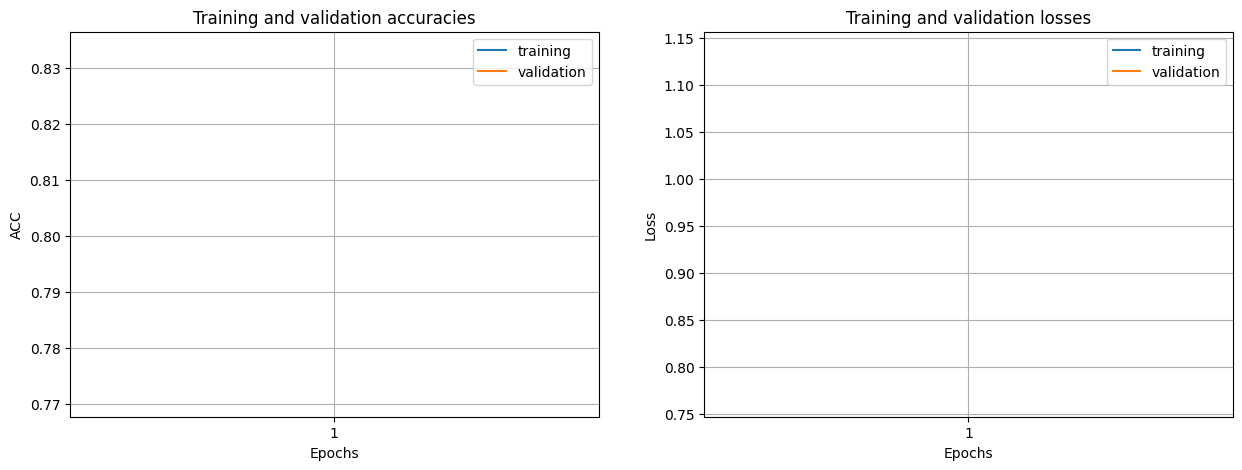

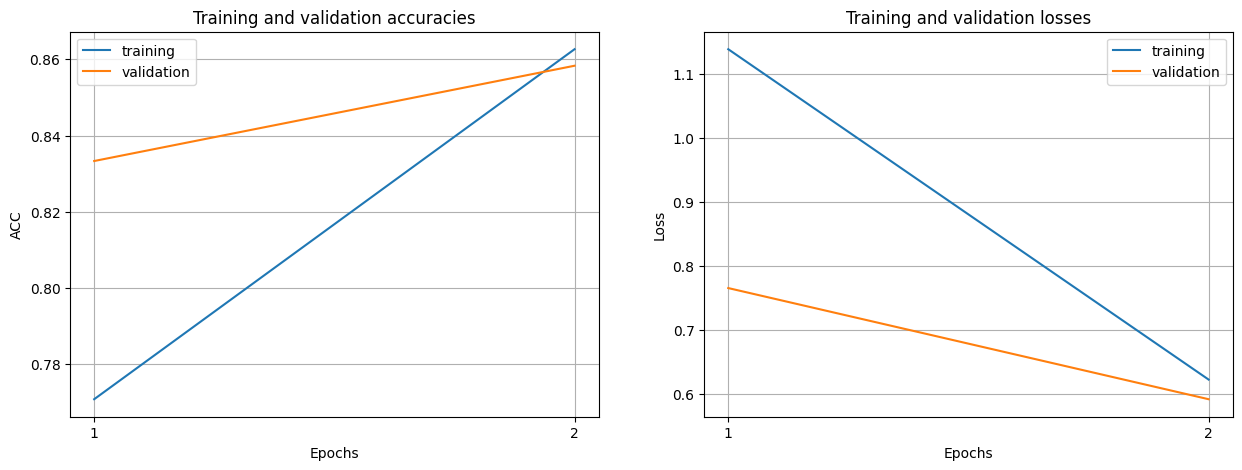

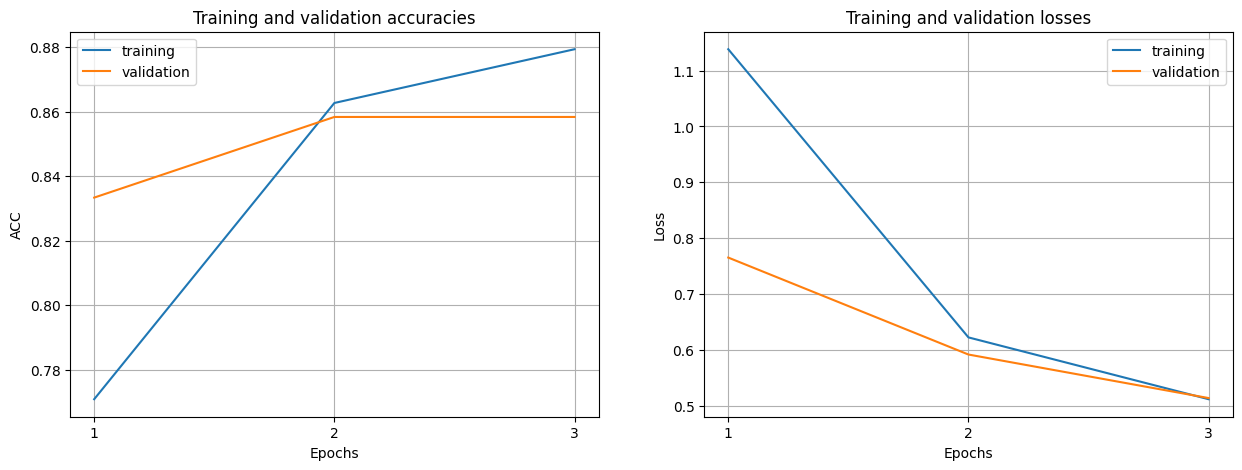

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MnistModel(device=device, embedding_size=bs.embedding_size).to(device)

# Train the model
experiment = fit(epochs=3, lr=0.001, model=model, train_loader=train_loader, val_loader=val_loader, bs=bs)


In [19]:
from model import evaluate


In [20]:
result = evaluate(model, val_loader, bs)
print(f"Validation Accuracy: {result['val_acc']:.2f}")


100%|██████████| 600/600 [06:35<00:00,  1.52it/s]

Validation Accuracy: 0.86
